In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog
from skimage import data, exposure
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2gray
from skimage.filters import gaussian

import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import local_binary_pattern
from skimage import exposure, filters, measure
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage import morphology
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.io import imread

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.19.0'

# Task2: Cell type classification

## Problem statement

**Objective**:
The objective of this task is to classify cell type data, which consists of four distinct categories: a, b, c, and others. This problem is framed as a multi-class classification problem, where each sample (an image of a cell) must be assigned one of the four labels based on its features. The dataset is imbalanced, meaning certain classes have far fewer samples than others, which introduces challenges in model evaluation.

**Metric Selection**:
Given the class imbalance present in the dataset, accuracy alone is not a sufficient evaluation metric. In this context, the weighted F1 score is the preferred metric. The F1 score is the harmonic mean of precision and recall, and it balances these two metrics to provide a more comprehensive evaluation.
Since we have an imbalanced dataset, the weighted F1 score is particularly useful because it gives more weight to the larger classes while still considering performance on the smaller classes. This helps ensure that the model performs well across all classes, not just the majority class, and avoids the bias that could arise from imbalanced class distributions. The weighted F1 score is calculated by averaging the F1 scores of each class, weighted by the number of instances in that class. This approach ensures that the model’s performance on minority classes is not overlooked.

**Baseline Model**:
For a baseline model, we will start with a Random Forest classifier. Random Forest is chosen because it is a robust, interpretable model well-suited for classification tasks, and it performs well on medium-sized datasets. Random Forest does not require extensive hyperparameter tuning and can provide a solid baseline for comparison with more advanced models.

**Improvement through Neural Networks**:
To improve upon the baseline, we will experiment with Neural Networks (NN) and Convolutional Neural Networks (CNNs). Neural networks, particularly CNNs, are highly specialized for image classification tasks as they can automatically learn hierarchical features and patterns from image data. CNNs have been shown to outperform traditional machine learning models in many image-related tasks due to their ability to capture spatial relationships in images. These models are expected to provide a significant boost in performance compared to the Random Forest baseline.

In [303]:
# Loading the data:
cell_type_train = pd.read_csv('./data/train.csv')
cell_type_train.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,19035,2,19035.png,fibroblast,0,0
1,19036,2,19036.png,fibroblast,0,0
2,19037,2,19037.png,fibroblast,0,0
3,19038,2,19038.png,fibroblast,0,0
4,19039,2,19039.png,fibroblast,0,0


In [304]:
cell_type_test = pd.read_csv('./data/test.csv')
cell_type_test.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


## Baseline development

For the baseline models, traditionals approaches, which support multiclass classification, are used, which are:
- Random Forest classifier:
- Support Vector Machine:

As the imbalance issue also happens for the cell type, data augmentation is used. Also, K-Fold is used for training and evaluating the Traditional Machine Learning approaches. 

### Features extraction
As the traditional machine learning approach could not handle the images as the input, so feature extracting is required to perform. 

In [65]:
sampled_df = cell_type_train.groupby('cellTypeName').sample(n=1, random_state=42).reset_index(drop=True)

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import local_binary_pattern
from skimage import exposure, filters
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import gaussian

def process_and_plot(image_path, title=""):
    # Load and preprocess image
    image = imread(image_path)
    grayscale = rgb2gray(image)

    # Gaussian smoothing
    smooth_1 = gaussian(image, sigma=1, channel_axis=-1)
    smooth_10 = gaussian(image, sigma=10, channel_axis=-1)

    # Sobel edge detection
    smooth_gray = gaussian(grayscale, sigma=1)
    edge_h = filters.sobel_h(smooth_gray)
    edge_v = filters.sobel_v(smooth_gray)

    # LBP feature extraction
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(grayscale, n_points, radius, method='uniform')

    # Normalize LBP histogram as feature vector
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype('float')
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Avoid divide by zero

    # Plot all results in a 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(6, 5))
    fig.suptitle(title, fontsize=16)

    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(smooth_1)
    axes[0, 1].set_title("Gaussian sigma=1")
    axes[0, 1].axis('off')

    axes[0, 2].imshow(smooth_10)
    axes[0, 2].set_title("Gaussian sigma=10")
    axes[0, 2].axis('off')

    axes[1, 0].imshow(edge_h, cmap='coolwarm')
    axes[1, 0].set_title("Sobel Horizontal")
    axes[1, 0].axis('off')

    axes[1, 1].imshow(edge_v, cmap='coolwarm')
    axes[1, 1].set_title("Sobel Vertical")
    axes[1, 1].axis('off')

    axes[1, 2].imshow(lbp, cmap='gray')
    axes[1, 2].set_title("LBP")
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print stats
    print(f"{title} -> Image shape: {image.shape}, Flattened: {np.prod(image.shape)}")
    print(f"{title} -> LBP hist shape: {lbp_hist.shape}, Sum: {np.sum(lbp_hist):.2f}")


In [115]:
# This function is used to extract the features, when training the data
class ImageFeatureExtractor:
    def process_and_extract_features(self, image_path, title=""):
        # Load and preprocess image
        image = imread(image_path)
        grayscale = rgb2gray(image)
        grayscale = (grayscale * 255).astype(np.uint8) 
    
        # Sobel edge detection
        smooth_gray = gaussian(grayscale, sigma=1) # when setting to sigma to higher value, most of features is gone
        edge_h = filters.sobel_h(smooth_gray)
        edge_v = filters.sobel_v(smooth_gray)
    
        # LBP feature extraction
        radius = 1
        n_points = 8 * radius
        lbp = local_binary_pattern(grayscale, n_points, radius, method='uniform')
    
        # Normalize LBP histogram as feature vector
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        lbp_hist = lbp_hist.astype('float')
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Avoid divide by zero
    
        # Extract color features (mean and std of RGB channels)
        mean_r = np.mean(image[:, :, 0])
        mean_g = np.mean(image[:, :, 1])
        mean_b = np.mean(image[:, :, 2])
        std_r = np.std(image[:, :, 0])
        std_g = np.std(image[:, :, 1])
        std_b = np.std(image[:, :, 2])
    
        # Threshold and label the image for segmentation (optional: you may have a different method)
        binary_image = grayscale > filters.threshold_otsu(grayscale)
        labeled_image = measure.label(binary_image)
        regions = measure.regionprops(labeled_image)
    
        # Extract shape features (area, perimeter, eccentricity, etc.)
        shape_features = []
        for region in regions:
            if region.area >= 10:  # Filter out small regions (noise)
                shape_features.extend([
                    region.area,
                    region.perimeter,
                    region.eccentricity,
                    region.solidity,
                    region.extent,
                    region.major_axis_length,
                    region.minor_axis_length,
                ])
        
        # Combine all features into one vector
        full_features = np.hstack([
            lbp_hist,
            [mean_r, mean_g, mean_b, std_r, std_g, std_b],
            # shape_features
        ])
    
        return full_features


./data/patch_images/471.png


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


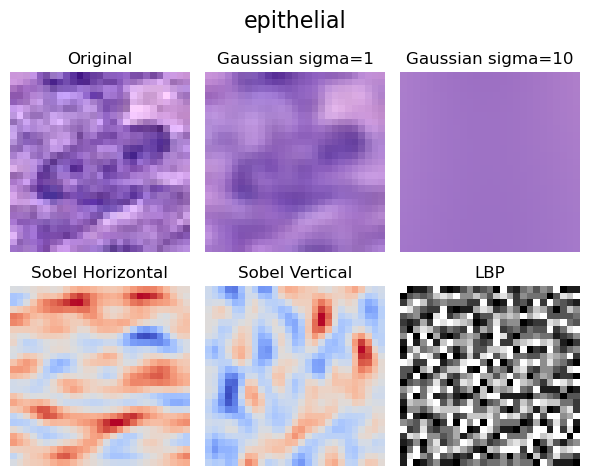

epithelial -> Image shape: (27, 27, 3), Flattened: 2187
epithelial -> LBP hist shape: (10,), Sum: 1.00
./data/patch_images/16787.png


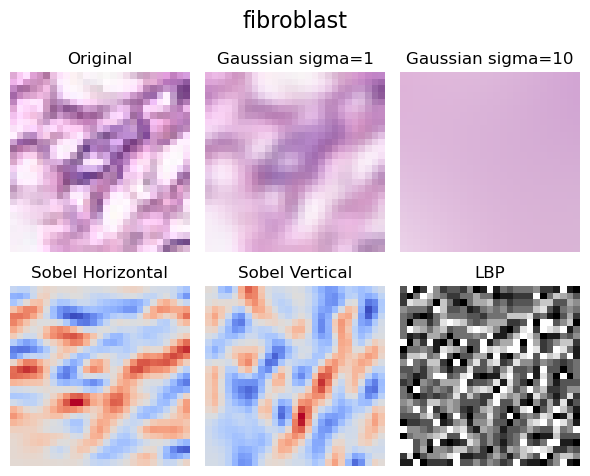

fibroblast -> Image shape: (27, 27, 3), Flattened: 2187
fibroblast -> LBP hist shape: (10,), Sum: 1.00
./data/patch_images/4702.png


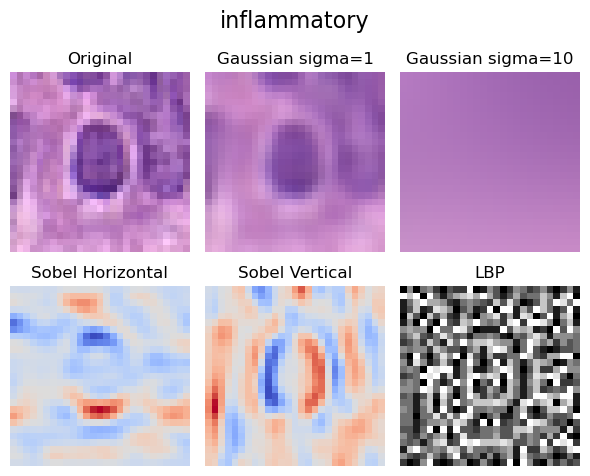

inflammatory -> Image shape: (27, 27, 3), Flattened: 2187
inflammatory -> LBP hist shape: (10,), Sum: 1.00
./data/patch_images/16651.png


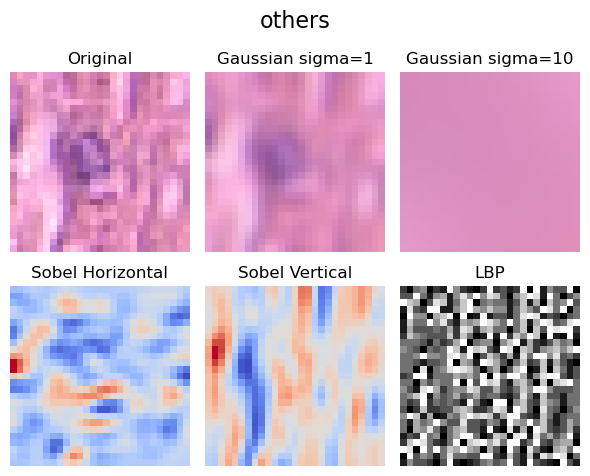

others -> Image shape: (27, 27, 3), Flattened: 2187
others -> LBP hist shape: (10,), Sum: 1.00


In [116]:
# Loop through the 4 sampled images
for idx, row in sampled_df.iterrows():
    image_path = './data/patch_images/' + row['ImageName']
    print(image_path)
    process_and_plot(image_path, title=row['cellTypeName'])


Based on the result of the above analysis, the LBP techniques capture the feature better than HOG. Therefore, the features, will be the combination of 

### Handle the imbalance class
As mentioned earlier, only 


In [147]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_X_y, check_array
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os

class AugmentedFeatureModel(BaseEstimator, ClassifierMixin):
    def __init__(self, image_dir, classifier_name, classifier=None, random_state=42):
        self.image_dir = image_dir
        self.classifier = classifier if classifier is not None else LogisticRegression(max_iter=1000)
        self.random_state = random_state
        self.feature_extractor = ImageFeatureExtractor()
        self.augment_times = 1
        self.image_aug_dir = f'./data/aug/{classifier_name}'
        os.makedirs(self.image_aug_dir, exist_ok=True)
        self.classifier_name = classifier_name

        # Define augmentation strategy
        self.augmentor = ImageDataGenerator(
            rescale=1./255,
            data_format='channels_last',
            rotation_range=15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            fill_mode='nearest'
        )

    def _augment_and_resample(self, X, y):
        import uuid
        df = X.copy()
        df['label'] = y
    
        counts = df['label'].value_counts()
        max_count = counts.max()
        balanced_rows = []
    
        for label in counts.index:
            samples = df[df['label'] == label]
            n_samples = samples.shape[0]
            required = max_count - n_samples
            sampled = samples.sample(n=required, replace=True, random_state=self.random_state)
    
            for _, row in sampled.iterrows():
                image_path = os.path.join(self.image_dir, row['ImageName'])
                original = load_img(image_path)
                x = img_to_array(original)
                x = x.reshape((1,) + x.shape)
                aug_iter = self.augmentor.flow(x, batch_size=1, shuffle=False)
                aug_image = next(aug_iter)[0] * 255.0
    
                # Save augmented image temporarily
                aug_fname = f"aug_{uuid.uuid4().hex[:8]}.png"
                aug_fpath = os.path.join(self.image_aug_dir, aug_fname)
                from PIL import Image
                Image.fromarray(aug_image.astype(np.uint8)).save(aug_fpath)
    
                balanced_rows.append({'ImageName': aug_fpath, 'label': label})
    
            # Add originals
            for _, row in samples.iterrows():
                image_fpath = os.path.join(self.image_dir, row['ImageName'])
                balanced_rows.append({'ImageName': image_fpath, 'label': label})
    
        df_balanced = pd.DataFrame(balanced_rows)
        return df_balanced[['ImageName']], df_balanced['label']


    def _extract_features(self, X_df, use_name_only=False):
        features = []
        for fname in X_df['ImageName']:
            if use_name_only is True:
                fname = os.path.join(self.image_dir, fname)
            feat = self.feature_extractor.process_and_extract_features(fname)
            features.append(feat)
        return np.array(features)

    def fit(self, X, y):
        # Augment + extract features
        X_balanced, y_balanced = self._augment_and_resample(X, y)
        self.le_ = LabelEncoder().fit(y_balanced)
        y_encoded = self.le_.transform(y_balanced)
        X_features = self._extract_features(X_balanced)
        self.classes_ = self.le_.classes_
        self.classifier.fit(X_features, y_encoded)
        return self

    def predict(self, X):
        X_features = self._extract_features(X, True)
        y_pred = self.classifier.predict(X_features)
        return self.le_.inverse_transform(y_pred)

    def predict_proba(self, X):
        X_features = self._extract_features(X, True)
        return self.classifier.predict_proba(X_features)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    


### Logistic regression

In [149]:
gkf = GroupKFold(n_splits=5)

folds = list(gkf.split(X, y, groups=groups))
# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(folds):
    # Extract training and validation patient IDs
    train_patient_ids = cell_type_train.iloc[train_idx]['patientID'].unique()
    val_patient_ids = cell_type_train.iloc[val_idx]['patientID'].unique()
    # Check if there is any overlap in patient IDs between train and validation sets
    overlap = set(train_patient_ids).intersection(val_patient_ids)
    if overlap:
        print(f"Data leakage detected in fold {fold + 1}: Overlap in patient IDs {overlap}")
    else:
        print(f"Fold {fold + 1} has no data leakage.")

Fold 1 has no data leakage.
Fold 2 has no data leakage.
Fold 3 has no data leakage.
Fold 4 has no data leakage.
Fold 5 has no data leakage.


In [150]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd


def evaluate_model_with_cv(model, model_name, param_grid, image_dir, df_train, df_test, folds, label_column='cellTypeName'):
    X_train = df_train[['ImageName']]
    y_train = df_train[label_column]
    groups = df_train['patientID']

    X_test = df_test[['ImageName']]
    y_test = df_test[label_column]

    # Wrap the model in AugmentedFeatureModel
    wrapped_model = AugmentedFeatureModel(
        image_dir=image_dir,
        classifier_name=model_name,
        classifier=model
    )

    grid = GridSearchCV(
        estimator=wrapped_model,
        param_grid=param_grid,
        cv=folds,
        scoring='f1_weighted',
        verbose=1,
        n_jobs=-1
    )

    print("🔍 Starting Grid Search...")
    grid.fit(X_train, y_train)
    print("✅ Best score:", grid.best_score_)
    print("✅ Best params:", grid.best_params_)

    # Final evaluation on the test set
    print("\n📊 Evaluating best model on test set...")
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_true = y_test

    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred))

    # ROC Curve (for multiclass)
    print("📈 Generating ROC Curve...")
    y_score = best_model.predict_proba(X_test)
    class_names = best_model.classes_
    y_true_bin = label_binarize(y_true, classes=class_names)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

    plt.figure(figsize=(8, 6))
    for class_name in class_names:
        plt.plot(fpr[class_name], tpr[class_name],
                 label=f'{class_name} (AUC = {roc_auc[class_name]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Multiclass)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


🔍 Starting Grid Search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Best score: 0.6124735587527871
✅ Best params: {'classifier__C': 1}

📊 Evaluating best model on test set...

📄 Classification Report:
              precision    recall  f1-score   support

  epithelial       0.83      0.89      0.86      1051
  fibroblast       0.66      0.55      0.60       307
inflammatory       0.74      0.82      0.78       618
      others       0.24      0.09      0.13       152

    accuracy                           0.77      2128
   macro avg       0.62      0.59      0.59      2128
weighted avg       0.74      0.77      0.75      2128

📈 Generating ROC Curve...


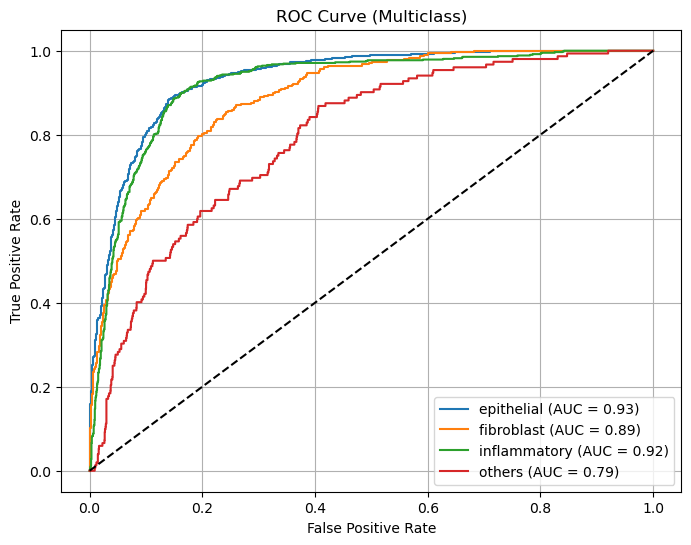

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Example: Logistic Regression
evaluate_model_with_cv(
    model=LogisticRegression(max_iter=100000, multi_class='multinomial', solver='lbfgs'),
    model_name="aug_logistic_clf",
    param_grid={'classifier__C': [0.1, 1, 10]},
    image_dir='./data/patch_images',
    df_train=cell_type_train,
    df_test=cell_type_test,
    folds=folds
)

### Random forest

🔍 Starting Grid Search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Best score: 0.6149975995435646
✅ Best params: {'classifier__max_depth': None, 'classifier__n_estimators': 100}

📊 Evaluating best model on test set...

📄 Classification Report:
              precision    recall  f1-score   support

  epithelial       0.78      0.87      0.83      1051
  fibroblast       0.58      0.52      0.55       307
inflammatory       0.72      0.69      0.71       618
      others       0.57      0.36      0.44       152

    accuracy                           0.73      2128
   macro avg       0.67      0.61      0.63      2128
weighted avg       0.72      0.73      0.72      2128

📈 Generating ROC Curve...


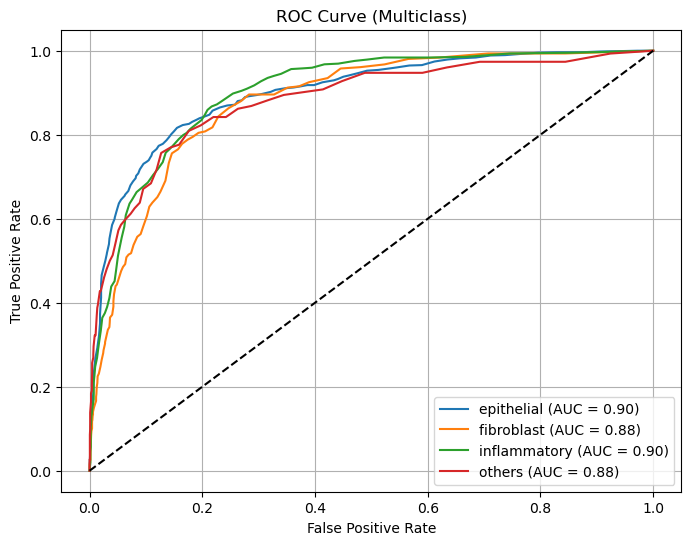

In [153]:
# Example: Random Forest
evaluate_model_with_cv(
    model=RandomForestClassifier(),
    model_name='aug_logistic_rf',
    param_grid={'classifier__n_estimators': [50, 100], 'classifier__max_depth': [None, 10]},
    image_dir='./data/patch_images',
    df_train=cell_type_train,
    df_test=cell_type_test,
    folds=folds
)


### Support Vector Machine

🔍 Starting Grid Search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Best score: 0.6188687508991612
✅ Best params: {'classifier__C': 10, 'classifier__kernel': 'linear'}

📊 Evaluating best model on test set...

📄 Classification Report:
              precision    recall  f1-score   support

  epithelial       0.83      0.88      0.85      1051
  fibroblast       0.60      0.55      0.57       307
inflammatory       0.74      0.82      0.78       618
      others       0.30      0.11      0.16       152

    accuracy                           0.76      2128
   macro avg       0.62      0.59      0.59      2128
weighted avg       0.73      0.76      0.74      2128

📈 Generating ROC Curve...


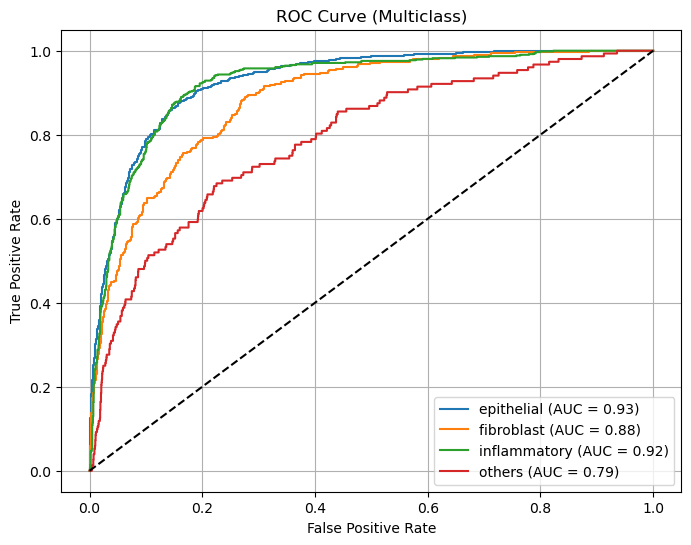

In [154]:

# Example: SVM
evaluate_model_with_cv(
    model=SVC(probability=True),  # `probability=True` needed for ROC
    model_name='aug_logistic_svm',
    param_grid={'classifier__C': [1, 10], 'classifier__kernel': ['linear', 'rbf']},
    image_dir='./data/patch_images',
    df_train=cell_type_train,
    df_test=cell_type_test,
    folds=folds
)

## Deep learning based approach

With deep learning approach, K-Fold validation could not be used as to split the train and validation set as training neural network is time-consuming process. 

In [308]:
from sklearn.model_selection import train_test_split

unique_patient_ids = cell_type_train['patientID'].unique()
train_patient_ids, val_patient_ids = train_test_split(
    unique_patient_ids, test_size=0.2, random_state=42, shuffle=True
)
# create masks based on patient ID
train_mask = cell_type_train['patientID'].isin(train_patient_ids)
val_mask = cell_type_train['patientID'].isin(val_patient_ids)

# Step 4: Split the dataframe
nn_train_celtype = cell_type_train[train_mask].reset_index(drop=True)
nn_val_celtype = cell_type_train[val_mask].reset_index(drop=True)

print(nn_train_celtype.shape)
print(nn_val_celtype.shape)

# Step 5: Confirm no data leakage
overlap = set(nn_train_celtype['patientID']).intersection(set(nn_val_celtype['patientID']))
if overlap:
    print(f"Data leakage detected: {overlap}")
else:
    print("No data leakage: train and validation sets are clean.")


(6623, 6)
(1145, 6)
No data leakage: train and validation sets are clean.


In [309]:
input_shape = (27, 27, 3)
output_classes = 4
celltype_ann = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(output_classes, activation='softmax')
])
celltype_ann.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_15 (Flatten)            │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1024)           │     2,240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,244,612 (8.56 MB)

 Trainable params: 2,244,612 (8.56 MB)

 Non-trainable params: 0 (0.00 B)

In [329]:
import os
import uuid
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image
import shutil
import math

class AugmentedImageModel:
    def __init__(self, image_dir, model, class_names, random_state=42, classifier_name="neural_net"):
        self.image_dir = image_dir
        self.model = model
        self.random_state = random_state
        self.class_names = class_names
        self.image_aug_dir = f'./data/aug/{classifier_name}'
        os.makedirs(self.image_aug_dir, exist_ok=True)
        self.classifier_name = classifier_name

        self.augmentor = ImageDataGenerator(
            rescale=1. / 255,
            data_format='channels_last',
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            brightness_range=[0.2,1.0],
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )

        self.final_generator = ImageDataGenerator(rescale=1. / 255)

    def _augment_and_resample(self, X, y):
        import uuid
        from PIL import Image
    
        df = X.copy()
        df['label'] = y
    
        counts = df['label'].value_counts()
        max_count = counts.max()
        balanced_rows = []
    
        for label in counts.index:
            samples = df[df['label'] == label]
            n_samples = samples.shape[0]
            required = max_count - n_samples
            sampled = samples.sample(n=required, replace=True, random_state=self.random_state)
    
            for _, row in sampled.iterrows():
                image_path = os.path.join(self.image_dir, row['ImageName'])
                original = load_img(image_path)
                x = img_to_array(original)
                x = x.reshape((1,) + x.shape)
                aug_iter = self.augmentor.flow(x, batch_size=1, shuffle=False)
                aug_image = next(aug_iter)[0] * 255.0
    
                # Save augmented image to the same directory
                aug_fname = f"aug_{uuid.uuid4().hex[:8]}.png"
                aug_fpath = os.path.join(self.image_aug_dir, aug_fname)
                Image.fromarray(aug_image.astype(np.uint8)).save(aug_fpath)
    
                balanced_rows.append({'ImageName': aug_fname, 'label': label})
    
            # Copy original images into the same folder and track
            for _, row in samples.iterrows():
                src_path = os.path.join(self.image_dir, row['ImageName'])
                dst_path = os.path.join(self.image_aug_dir, row['ImageName'])
                if not os.path.exists(dst_path):
                    shutil.copy(src_path, dst_path)
                balanced_rows.append({'ImageName': row['ImageName'], 'label': label})
    
        df_balanced = pd.DataFrame(balanced_rows)
        return df_balanced


    def train(self, X, y, batch_size=16, epochs=50, validation_data=None, verbose=1):
        df_balanced = self._augment_and_resample(X, y)
        print("🔍 Class distribution after balancing:")
        print(df_balanced['label'].value_counts())
        train_gen = self.final_generator.flow_from_dataframe(
            dataframe=df_balanced,
            directory= self.image_aug_dir,
            x_col='ImageName',
            y_col='label',
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True,
            classes=self.class_names
        )

        val_gen = None
        if validation_data:
            X_val, y_val = validation_data
            val_df = X_val.copy()
            val_df['label'] = y_val
            val_gen = self.final_generator.flow_from_dataframe(
                dataframe=val_df,
                directory=self.image_dir,
                x_col='ImageName',
                y_col='label',
                target_size=(27, 27),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=False,
                classes=self.class_names
            )
            validation_steps = math.ceil(len(val_df) / batch_size)

        steps_per_epoch = math.ceil(len(df_balanced) / batch_size)
        self.history = self.model.fit(
            train_gen,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_gen,
            validation_steps=validation_steps,
            epochs=epochs,
            verbose=verbose
        )
        return self.history

    def predict(self, X):
        df = X.copy()
        df['label'] = 'unknown'  # dummy
        pred_gen = self.final_generator.flow_from_dataframe(
            dataframe=df,
            directory=self.image_dir,
            x_col='ImageName',
            y_col='label',
            target_size=(27, 27),
            batch_size=16,
            class_mode=None,
            shuffle=False,
        )
        
        preds = self.model.predict(pred_gen)
        return [self.class_names[i] for i in np.argmax(preds, axis=1)]

    def predict_proba(self, X):
        df = X.copy()
        df['label'] = 'unknown'
        pred_gen = self.final_generator.flow_from_dataframe(
            dataframe=df,
            directory=self.image_dir,
            x_col='ImageName',
            y_col='label',
            target_size=(27, 27),
            batch_size=16,
            class_mode=None,
            shuffle=False,
        )
        return self.model.predict(pred_gen)

    def classes_(self):
        return self.class_names


In [330]:
# Assuming you have a compiled Keras model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

celltype_ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                     metrics=[
        CategoricalAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall')
    ])

image_model = AugmentedImageModel(
    image_dir='./data/patch_images',
    model=celltype_ann,
    class_names=['0', '1', '2', '3']
)

history = image_model.train(
    X=nn_train_celtype[['ImageName']],
    y=nn_train_celtype['cellType'].astype(str),
    validation_data=(nn_val_celtype[['ImageName']], nn_val_celtype['cellType'].astype(str)),
    epochs=50
)


🔍 Class distribution after balancing:
label
2    2807
1    2807
0    2807
3    2807
Name: count, dtype: int64
Found 11228 validated image filenames belonging to 4 classes.
Found 1145 validated image filenames belonging to 4 classes.
Epoch 1/50


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6850 - loss: 0.7377 - precision: 0.7584 - recall: 0.5744 - val_accuracy: 0.5520 - val_loss: 1.4724 - val_precision: 0.5787 - val_recall: 0.4978
Epoch 2/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6894 - loss: 0.7073 - precision: 0.7688 - recall: 0.5826 - val_accuracy: 0.5127 - val_loss: 1.3427 - val_precision: 0.5452 - val_recall: 0.4428
Epoch 3/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6965 - loss: 0.7134 - precision: 0.7617 - recall: 0.5956 - val_accuracy: 0.4489 - val_loss: 1.5313 - val_precision: 0.4797 - val_recall: 0.3913
Epoch 4/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6875 - loss: 0.7161 - precision: 0.7642 - recall: 0.5850 - val_accuracy: 0.5904 - val_loss: 1.1492 - val_precision: 0.6159 - val_recall: 0.5293
Epoch 5/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6972 - loss: 0.7110 - precision: 0.7752 - recall: 0.5962 - val_accuracy: 0.5869 - val_loss: 1.2699 - val_

2128
2128
Found 2128 validated image filenames.
 48/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.56      0.62       307
           1       0.75      0.76      0.76       618
           2       0.86      0.90      0.88      1051
           3       0.22      0.24      0.23       152

    accuracy                           0.76      2128
   macro avg       0.64      0.61      0.62      2128
weighted avg       0.76      0.76      0.76      2128


 Weighted F1 Score
0.7610225864335118
📈 Generating ROC Curve...
Found 2128 validated image filenames.
 86/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


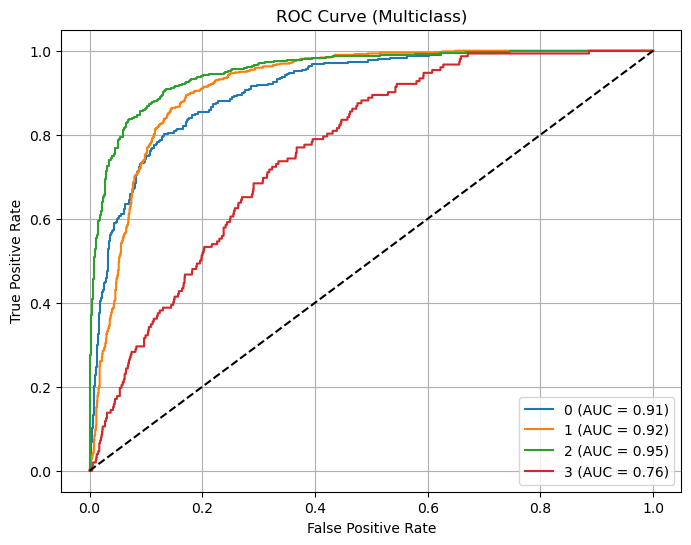

In [332]:
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def evaluate_model(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    y_true = y_test

    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred))
    print("\n Weighted F1 Score")
    print(f1_score(y_true, y_pred, average='weighted'))

    # ROC Curve (for multiclass)
    print("📈 Generating ROC Curve...")
    y_score = best_model.predict_proba(X_test)
    class_names = best_model.class_names
    y_true_bin = label_binarize(y_true, classes=class_names)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

    plt.figure(figsize=(8, 6))
    for class_name in class_names:
        plt.plot(fpr[class_name], tpr[class_name],
                 label=f'{class_name} (AUC = {roc_auc[class_name]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Multiclass)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

print(len(X_test))
print(len(y_test))
X_test = cell_type_test[['ImageName']]
y_test = cell_type_test['cellType'].astype(str)
evaluate_model(image_model, X_test, y_test)


In [301]:
reg_lambda = 0.001
model_leNet_aug = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [293]:
# Assuming you have a compiled Keras model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

model_leNet_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                     metrics=[
        CategoricalAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall')
    ])

image_model = AugmentedImageModel(
    image_dir='./data/patch_images',
    model=model_leNet_aug,
    class_names=['0', '1', '2', '3'],
    classifier_name='cnn'
)

history = image_model.train(
    X=nn_train_celtype[['ImageName']],
    y=nn_train_celtype['cellType'].astype(str),
    validation_data=(nn_val_celtype[['ImageName']], nn_val_celtype['cellType'].astype(str)),
    epochs=100
)


🔍 Class distribution after balancing:
label
2    2807
1    2807
0    2807
3    2807
Name: count, dtype: int64
Found 11228 validated image filenames belonging to 4 classes.
Found 1145 validated image filenames belonging to 4 classes.
Epoch 1/100


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2564 - loss: 1.4261 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5223 - val_loss: 1.3542 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3717 - loss: 1.3598 - precision: 0.4108 - recall: 0.0051 - val_accuracy: 0.5092 - val_loss: 1.2566 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4727 - loss: 1.2561 - precision: 0.7475 - recall: 0.0777 - val_accuracy: 0.5616 - val_loss: 1.1588 - val_precision: 0.6872 - val_recall: 0.1074
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4937 - loss: 1.1497 - precision: 0.7505 - recall: 0.1893 - val_accuracy: 0.5546 - val_loss: 1.1288 - val_precision: 0.7108 - val_recall: 0.1266
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5196 - loss: 1.1109 - precision: 0.7376 - recall: 0.2045 - val_accuracy: 0.38

Found 2128 validated image filenames.
 1/67 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:854: UserWarning: `classes` will be ignored given the class_mode="None"
  warnings.warn(
/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       307
           1       0.80      0.61      0.69       618
           2       0.85      0.92      0.88      1051
           3       0.20      0.34      0.25       152

    accuracy                           0.74      2128
   macro avg       0.64      0.62      0.62      2128
weighted avg       0.77      0.74      0.75      2128


 Weighted F1 Score
0.7497060148380713
📈 Generating ROC Curve...
Found 2128 validated image filenames.
25/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:854: UserWarning: `classes` will be ignored given the class_mode="None"
  warnings.warn(
/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


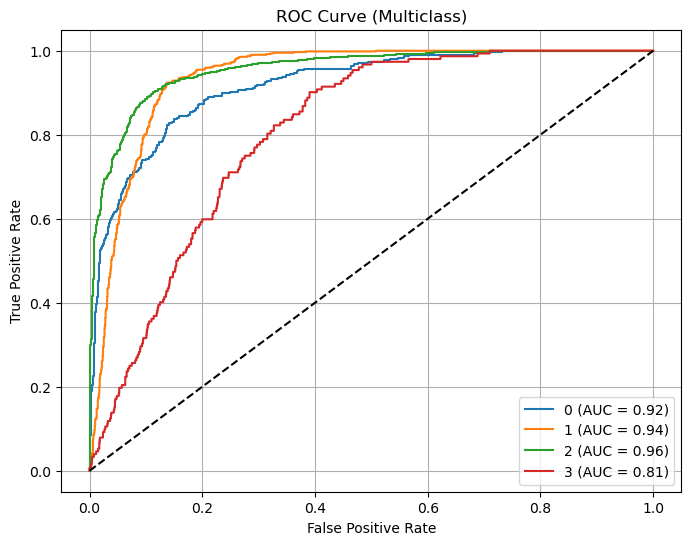

In [294]:
evaluate_model(image_model, X_test, y_test)


## Using extra data to improve the current accuracy

Analysis on the given data: 
The given data does not have the labels for the cell type but only with the cancerous status. So, one possible way is to train the embeddings via the encoder/decoder neural network (i.e. similar to what BERT do), then fine tuned on the given dataset. 

Running the transfer learning: https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets
